# Notebook pour répondre aux questions de la partie 3

In stores many decisions are made by managers at the department level.  
In order to help store managers in making mid-term decisions driven by economic data, we want to forecast the turnover for the next 8 weeks at store-department level.

## a. Build an estimator able to predict the turnover of test.csv.gz data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Preprocessing

In [2]:
df_train = pd.read_csv('../data/train.csv')
df_train['day_id'] = pd.to_datetime(df_train['day_id'], format='%Y-%m-%d')
df_train['year'] = df_train['day_id'].dt.year
df_train['month'] = df_train['day_id'].dt.month
df_train['day'] = df_train['day_id'].dt.day

In [3]:
df_test = pd.read_csv('../data/test.csv')
df_test['day_id'] = pd.to_datetime(df_test['day_id'], format='%Y-%m-%d')
df_test['year'] = df_test['day_id'].dt.year
df_test['month'] = df_test['day_id'].dt.month
df_test['day'] = df_test['day_id'].dt.day

In [4]:
# concatenate two string columns and add a dash in between
df_train['store-dep'] = df_train['but_num_business_unit'].astype(str) + '-' + df_train['dpt_num_department'].astype(str)
df_test['store-dep'] = df_test['but_num_business_unit'].astype(str) + '-' + df_test['dpt_num_department'].astype(str)

In [6]:
df_train.sort_values(by=['store-dep','day_id'], inplace=True)

In [39]:
# backfill THE outlier of store-dep 30-88

df_train.loc[231272, 'turnover'] = np.nan
df_train['turnover'] = df_train['turnover'].bfill()

In [40]:

df_train[(df_train['store-dep'] == '30-88') & (df_train['turnover'] > 100000)]

,day_id,but_num_business_unit,dpt_num_department,turnover,year,month,day,store-dep,is_outlier,rolling_mean,rolling_std,is_outlier_rolling


In [27]:
df_train['is_outlier'] = False
for store_dep in df_train['store-dep'].unique():
    # check for outliers in the turnover column
    df_store_dep = df_train[df_train['store-dep'] == store_dep]
    Q1 = df_store_dep['turnover'].quantile(0.25)
    Q3 = df_store_dep['turnover'].quantile(0.75)
    IQR = Q3 - Q1
    df_outliers = df_store_dep[(df_store_dep['turnover'] < (Q1 - 3 * IQR)) | (df_store_dep['turnover'] > (Q3 + 3 * IQR))]
    df_train.loc[df_outliers.index, 'is_outlier'] = True
    


In [44]:
# find outliers based on rolling average of the timeseries
df_train['rolling_mean'] = df_train.groupby('store-dep')['turnover'].transform(lambda x: x.rolling(window=10, center=True).mean())
df_train['rolling_std'] = df_train.groupby('store-dep')['turnover'].transform(lambda x: x.rolling(window=10, center=True).std())
df_train['is_outlier_rolling'] = False
df_train['is_outlier_rolling'] = df_train['is_outlier_rolling'] | (df_train['turnover'] < df_train['rolling_mean'] - 3 * df_train['rolling_std'])
df_train['is_outlier_rolling'] = df_train['is_outlier_rolling'] | (df_train['turnover'] > df_train['rolling_mean'] + 3 * df_train['rolling_std'])


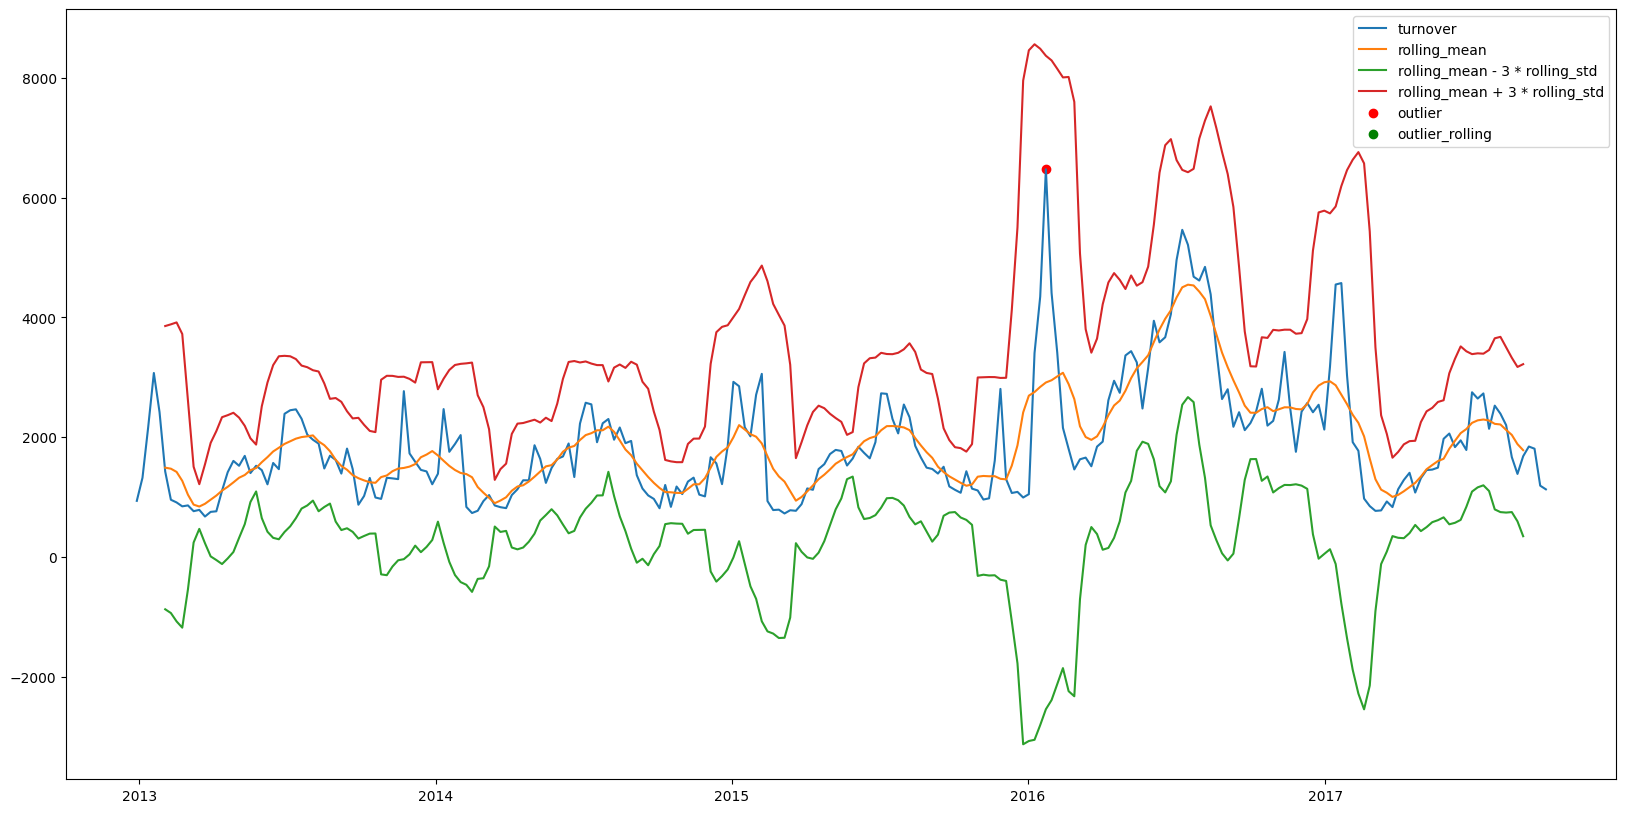

In [47]:
import random

store_dep = random.choice(df_train['store-dep'].unique())
df_store_dep = df_train[df_train['store-dep'] == store_dep]
plt.figure(figsize=(20,10))
plt.plot(df_store_dep['day_id'], df_store_dep['turnover'], label='turnover')
plt.plot(df_store_dep['day_id'], df_store_dep['rolling_mean'], label='rolling_mean')
plt.plot(df_store_dep['day_id'], df_store_dep['rolling_mean'] - 3 * df_store_dep['rolling_std'], label='rolling_mean - 3 * rolling_std')
plt.plot(df_store_dep['day_id'], df_store_dep['rolling_mean'] + 3 * df_store_dep['rolling_std'], label='rolling_mean + 3 * rolling_std')
plt.scatter(df_store_dep[df_store_dep['is_outlier']].day_id, df_store_dep[df_store_dep['is_outlier']].turnover, color='red', label='outlier')
plt.scatter(df_store_dep[df_store_dep['is_outlier_rolling']].day_id, df_store_dep[df_store_dep['is_outlier_rolling']].turnover, color='green', label='outlier_rolling')
plt.legend()
plt.show()
 

In [48]:
df_train['is_outlier'] = df_train['is_outlier'] & df_train['is_outlier_rolling']

In [49]:
df_train[df_train['is_outlier']]

,day_id,but_num_business_unit,dpt_num_department,turnover,year,month,day,store-dep,is_outlier,rolling_mean,rolling_std,is_outlier_rolling


<Axes: xlabel='day_id'>

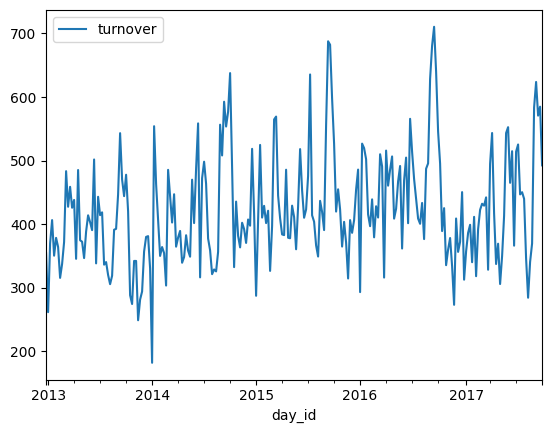

In [50]:
df_train[df_train['store-dep'] == '30-88'].plot(x='day_id', y='turnover')

### Timeseries modeling

In [32]:
from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(
    n_splits=2,
    test_size=10000,
)

In [33]:
df_train.head()

,day_id,but_num_business_unit,dpt_num_department,turnover,year,month,day,store-dep
0,2017-09-30,64,127,580.308443,2017,9,30,64-127
1,2017-09-30,119,127,1512.995918,2017,9,30,119-127
2,2017-09-30,4,88,668.593556,2017,9,30,4-88
3,2017-09-30,425,127,0.000000,2017,9,30,425-127
4,2017-09-30,513,73,0.000000,2017,9,30,513-73


In [34]:
X = df_train[['store-dep', 'year', 'month', 'day']]
y = df_train['turnover']

In [35]:
dataset_splits = list(ts_cv.split(X, y))
train_0, valid_0 = dataset_splits[0]

In [36]:
X.iloc[valid_0]

,store-dep,year,month,day
257719,363-127,2013,5,11
257720,156-127,2013,5,11
257721,496-117,2013,5,11
257722,692-73,2013,5,11
257723,151-117,2013,5,11
...,...,...,...,...
267714,116-117,2013,3,2
267715,296-73,2013,3,2
267716,345-127,2013,3,2
267717,127-73,2013,3,2


In [37]:
from catboost import Pool, CatBoostRegressor

train_pool = Pool(
    data=X.iloc[train_0],
    label=y.iloc[train_0],
    cat_features=['store-dep'],
)

valid_pool = Pool(
    data=X.iloc[valid_0],
    label=y.iloc[valid_0],
    cat_features=['store-dep'],
)

model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='RMSE',
    verbose=10,
)

model.fit(train_pool, eval_set=valid_pool)



0:	learn: 2167.9602815	test: 481.6330786	best: 481.6330786 (0)	total: 78.6ms	remaining: 1m 18s
10:	learn: 2101.6887660	test: 344.4996950	best: 344.4996950 (10)	total: 226ms	remaining: 20.3s
20:	learn: 2084.4624687	test: 316.1637386	best: 316.1637386 (20)	total: 371ms	remaining: 17.3s
30:	learn: 2076.7786433	test: 303.2028147	best: 303.2028147 (30)	total: 521ms	remaining: 16.3s
40:	learn: 2071.7621043	test: 296.3544523	best: 296.3544523 (40)	total: 663ms	remaining: 15.5s
50:	learn: 2069.0635077	test: 294.2434899	best: 294.2434899 (50)	total: 809ms	remaining: 15s
60:	learn: 2067.0223169	test: 291.5425973	best: 291.5425973 (60)	total: 954ms	remaining: 14.7s
70:	learn: 2065.5734474	test: 290.1779223	best: 290.1203229 (69)	total: 1.1s	remaining: 14.4s
80:	learn: 2063.9614957	test: 287.4799531	best: 287.4799531 (80)	total: 1.25s	remaining: 14.2s
90:	learn: 2062.1252125	test: 286.9251086	best: 286.9251086 (90)	total: 1.39s	remaining: 13.9s
100:	learn: 2061.6239073	test: 286.0136500	best: 285.

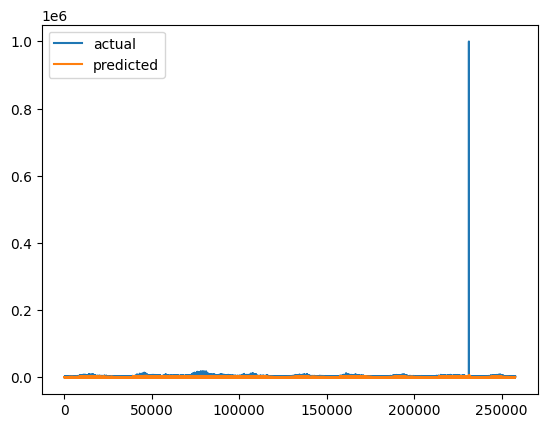

In [41]:
# plot predictions and actual values on the training set
y_pred = model.predict(train_pool)
plt.plot(y.iloc[train_0], label='actual')
plt.plot(y_pred, label='predicted')
plt.legend()
plt.show()


In [ ]:
df_test['turnover'] = model.predict(df_test[['store-dep', 'year', 'month', 'day']])